# 21-1. 프로젝트 : 스티커를 붙여주자

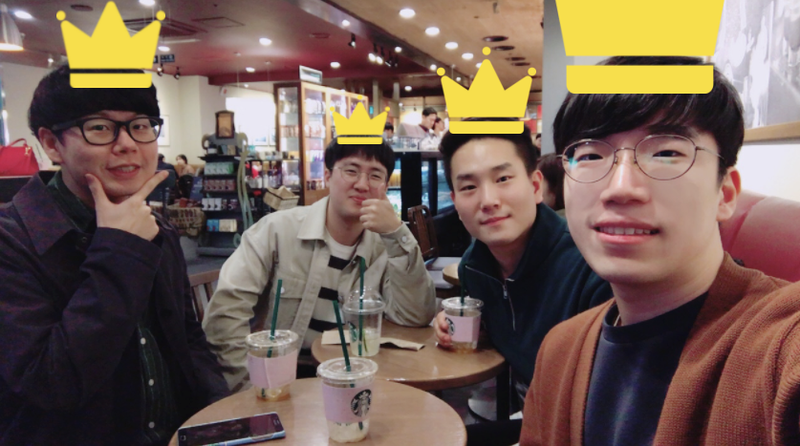
드디어 딥러닝 모델을 이용해 우리의 스티커앱을 개선해서, 이미지 속 다수의 사람에게 스티커를 붙여줄 수 있게 되었습니다. 위 그림의 예시처럼 말이죠.

여러분들도 여러분들의 작품을 통해 이 작업을 본격적으로 수행해 봅시다. 첫 번째 스텝에서 제공해 드린 프로젝트 코드를 적극적으로 활용하셔도 좋습니다.

## 라이브러리 버전 확인
---
사용할 주요 라이브러리 버전을 확인해봅니다.

In [1]:
import tensorflow as tf
import numpy as np
import cv2
tf.random.set_seed(1000)


print(tf.__version__)
print(np.__version__)
print(cv2.__version__)

2.6.0
1.21.4
4.5.3


# 데이터 준비하기

In [2]:
# ! mkdir -p ~/aiffel/face_detector/assets
# ! mkdir -p ~/aiffel/face_detector/dataset

In [3]:
# ! ln -s ~/data/* ~/aiffel/face_detector

# 데이터셋 전처리(1) 분석

## WIDER FACE Bounding Box
---
오늘 다루게 될 WIDER FACE 데이터셋은 Face detection을 위한 데이터셋이고, 입력데이터는 이미지 파일로, Ground Truth는 Bounding box 정보로 되어 있습니다. 이전 스텝에서 준비한 데이터는 4개의 디렉토리에 들어있습니다.

In [4]:
!cd ~/aiffel/face_detector/widerface && ls wider_face_split  WIDER_test  WIDER_train  WIDER_val

wider_face_split:
readme.txt		      wider_face_train_bbx_gt.txt  wider_face_val.mat
wider_face_test_filelist.txt  wider_face_train.mat
wider_face_test.mat	      wider_face_val_bbx_gt.txt

WIDER_test:
images

WIDER_train:
images

WIDER_val:
images


여기서 WIDER_xxxx 로 되어 있는 3개의 디렉토리에는 입력용 이미지 파일만 들어 있습니다. 좀더 구체적으로 분석해 보아야 할 것은 wider_face_split 디렉토리 내에 있는 wider_face_train_bbx_gt.txt과 wider_face_val_bbx_gt.txt, 이 2개 파일 안에 포함되어 있는 Bounding box 정보입니다.

실제 이 파일들이 어떻게 생겼는지 열어볼까요?

In [5]:
!cd ~/aiffel/face_detector/widerface/wider_face_split && head -20 wider_face_train_bbx_gt.txt

0--Parade/0_Parade_marchingband_1_849.jpg
1
449 330 122 149 0 0 0 0 0 0 
0--Parade/0_Parade_Parade_0_904.jpg
1
361 98 263 339 0 0 0 0 0 0 
0--Parade/0_Parade_marchingband_1_799.jpg
21
78 221 7 8 2 0 0 0 0 0 
78 238 14 17 2 0 0 0 0 0 
113 212 11 15 2 0 0 0 0 0 
134 260 15 15 2 0 0 0 0 0 
163 250 14 17 2 0 0 0 0 0 
201 218 10 12 2 0 0 0 0 0 
182 266 15 17 2 0 0 0 0 0 
245 279 18 15 2 0 0 0 0 0 
304 265 16 17 2 0 0 0 2 1 
328 295 16 20 2 0 0 0 0 0 
389 281 17 19 2 0 0 0 2 0 
406 293 21 21 2 0 1 0 0 0 


In [6]:
import os, cv2, time
import tensorflow as tf
import tqdm
import numpy as np
import math
from itertools import product
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME')+'/aiffel/face_detector'
DATA_PATH = os.path.join(PROJECT_PATH, 'widerface')
MODEL_PATH = os.path.join(PROJECT_PATH, 'checkpoints')
TRAIN_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'train_mask.tfrecord')
VALID_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'val_mask.tfrecord')
CHECKPOINT_PATH = os.path.join(PROJECT_PATH, 'checkpoints')

DATASET_LEN = 12880
BATCH_SIZE = 32
IMAGE_WIDTH = 320
IMAGE_HEIGHT = 256
IMAGE_LABELS = ['background', 'face']

print(tf.__version__)

2.6.0


먼저 bounding box 파일을 분석해 봅시다. 분석에 필요한 코드를 함수 형태로 준비할게요.

In [7]:
def parse_box(data):
    x0 = int(data[0])
    y0 = int(data[1])
    w = int(data[2])
    h = int(data[3])
    return x0, y0, w, h

print('슝=3')

슝=3


In [8]:
def parse_widerface(file):
    infos = []
    with open(file) as fp:
        line = fp.readline()
        while line:
            n_object = int(fp.readline())
            boxes = []
            for i in range(n_object):
                box = fp.readline().split(' ')
                x0, y0, w, h = parse_box(box)
                if (w == 0) or (h == 0):
                    continue
                boxes.append([x0, y0, w, h])
            if n_object == 0:
                box = fp.readline().split(' ')
                x0, y0, w, h = parse_box(box)
                boxes.append([x0, y0, w, h])
            infos.append((line.strip(), boxes))
            line = fp.readline()
    return infos

print('슝=3')

슝=3


위 함수는 이미지별 bounding box 정보를 wider_face_train_bbx_gt.txt에서 파싱해서 리스트로 추출하는 것입니다.

이제 추출된 정보를 실제 이미지 정보와 결합합니다. bounding box 정보는 [x, y, w, h] 형태로 저장되어 있는데, [x_min, y_min, x_max, y_max] 형태의 꼭짓점 좌표 정보로 변환할 거예요.

이렇게 정보를 결합해야 나중에 학습에 사용하기 좋습니다.

In [9]:
def process_image(image_file):
    image_string = tf.io.read_file(image_file)
    try:
        image_data = tf.image.decode_jpeg(image_string, channels=3)
        return 0, image_string, image_data
    except tf.errors.InvalidArgumentError:
        return 1, image_string, None

print('슝=3')

슝=3


In [10]:
def xywh_to_voc(file_name, boxes, image_data):
    shape = image_data.shape
    image_info = {}
    image_info['filename'] = file_name
    image_info['width'] = shape[1]
    image_info['height'] = shape[0]
    image_info['depth'] = 3

    difficult = []
    classes = []
    xmin, ymin, xmax, ymax = [], [], [], []

    for box in boxes:
        classes.append(1)
        difficult.append(0)
        xmin.append(box[0])
        ymin.append(box[1])
        xmax.append(box[0] + box[2])
        ymax.append(box[1] + box[3])
    image_info['class'] = classes
    image_info['xmin'] = xmin
    image_info['ymin'] = ymin
    image_info['xmax'] = xmax
    image_info['ymax'] = ymax
    image_info['difficult'] = difficult

    return image_info

print('슝=3')

슝=3


잘 결합된 데이터의 형태를 확인해 봅시다. 5개만 출력해 볼 거예요.

In [11]:
file_path = os.path.join(DATA_PATH, 'wider_face_split', 'wider_face_train_bbx_gt.txt')
for i, info in enumerate(parse_widerface(file_path)):
    print('--------------------')
    image_file = os.path.join(DATA_PATH, 'WIDER_train', 'images', info[0])
    _, image_string, image_data = process_image(image_file)
    boxes = xywh_to_voc(image_file, info[1], image_data)
    print(boxes)
    if i > 3:
        break

--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_849.jpg', 'width': 1024, 'height': 1385, 'depth': 3, 'class': [1], 'xmin': [449], 'ymin': [330], 'xmax': [571], 'ymax': [479], 'difficult': [0]}
--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_Parade_0_904.jpg', 'width': 1024, 'height': 1432, 'depth': 3, 'class': [1], 'xmin': [361], 'ymin': [98], 'xmax': [624], 'ymax': [437], 'difficult': [0]}
--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_799.jpg', 'width': 1024, 'height': 768, 'depth': 3, 'class': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'xmin': [78, 78, 113, 134, 163, 201, 182, 245, 304, 328, 389, 406, 436, 522, 643, 653, 793, 535, 29, 3, 20], 'ymin': [221, 238, 212, 260, 250, 218, 266, 279, 265, 295, 281, 293, 290, 328, 320, 224, 337, 311, 22

어떤가요? 이미지별로 boxes 리스트에 담긴 bounding box 정보가 확인되시나요? 이제 이 정보를 활용하여 텐서플로우 데이터셋을 생성해 봅시다.

# 데이터셋 전처리(2) TFRecord 생성

## TFRecord 만들기
---
오늘 다루게 될 대용량 데이터셋의 처리속도 향상을 위해서, 전처리 작업을 통해 TFRecord 데이터셋으로 변환할 필요가 있습니다. TFRecord란 TensorFlow만의 학습 데이터 저장 포맷으로, 이진(binary) 레코드의 시퀀스를 저장합니다. TFRecord 형태의 학습 데이터를 사용하여 모델 학습을 하면 학습 속도가 개선된다는 장점이 있습니다.

TFRecord는 여러 개의 tf.train.Example로 이루어져 있고, 한 개의 tf.train.Example은 여러 개의 tf.train.Feature로 이루어져 있습니다.

데이터의 단위를 이루는 tf.train.Example 인스턴스를 생성하는 메소드는 아래와 같습니다.

In [12]:
def make_example(image_string, image_infos):
    for info in image_infos:
        filename = info['filename']
        width = info['width']
        height = info['height']
        depth = info['depth']
        classes = info['class']
        xmin = info['xmin']
        ymin = info['ymin']
        xmax = info['xmax']
        ymax = info['ymax']

    if isinstance(image_string, type(tf.constant(0))):
        encoded_image = [image_string.numpy()]
    else:
        encoded_image = [image_string]

    base_name = [tf.compat.as_bytes(os.path.basename(filename))]
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'filename':tf.train.Feature(bytes_list=tf.train.BytesList(value=base_name)),
        'height':tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'width':tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'classes':tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
        'x_mins':tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
        'y_mins':tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
        'x_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
        'y_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
        'image_raw':tf.train.Feature(bytes_list=tf.train.BytesList(value=encoded_image))
    }))
    
    return example

print('슝=3')

슝=3


In [13]:
for split in ['train', 'val']:
    if split == 'train':
        output_file = TRAIN_TFRECORD_PATH 
        anno_txt = 'wider_face_train_bbx_gt.txt'
        file_path = 'WIDER_train'
    else:
        output_file = VALID_TFRECORD_PATH
        anno_txt = 'wider_face_val_bbx_gt.txt'
        file_path = 'WIDER_val'

    with tf.io.TFRecordWriter(output_file) as writer:
        for info in tqdm.tqdm(parse_widerface(os.path.join(DATA_PATH, 'wider_face_split', anno_txt))):
            image_file = os.path.join(DATA_PATH, file_path, 'images', info[0])
            error, image_string, image_data = process_image(image_file)
            boxes = xywh_to_voc(image_file, info[1], image_data)

            if not error:
                tf_example = make_example(image_string, [boxes])
                writer.write(tf_example.SerializeToString())

100%|██████████| 3226/3226 [00:13<00:00, 235.92it/s]


In [14]:
!ls ~/aiffel/face_detector/dataset

train_mask.tfrecord  val_mask.tfrecord


- 이번 프로젝트에서 사용할 default box 정보를 전역 변수로 만들어 둡니다.

In [15]:
BOX_MIN_SIZES = [[10, 16, 24], [32, 48], [64, 96], [128, 192, 256]]
BOX_STEPS = [8, 16, 32, 64]

print('슝=3')

슝=3


In [16]:
image_sizes = (IMAGE_HEIGHT, IMAGE_WIDTH)
min_sizes = BOX_MIN_SIZES
steps= BOX_STEPS

feature_maps = [
    [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
    for step in steps
]
feature_maps

[[32, 40], [16, 20], [8, 10], [4, 5]]

이제 feature map별로 순회를 하면서 default box 를 생성해 보겠습니다.

In [17]:
boxes = []
for k, f in enumerate(feature_maps):
    for i, j in product(range(f[0]), range(f[1])):
        for min_size in min_sizes[k]:
            s_kx = min_size / image_sizes[1]
            s_ky = min_size / image_sizes[0]
            cx = (j + 0.5) * steps[k] / image_sizes[1]
            cy = (i + 0.5) * steps[k] / image_sizes[0]
            boxes += [cx, cy, s_kx, s_ky]

len(boxes)

18800

생성된 boxes에는 default box 정보가 구분없이 나열되어 있으므로 4개씩 재배열 시켜줄게요.

In [18]:
pretty_boxes = np.asarray(boxes).reshape([-1, 4])
print(pretty_boxes.shape)
print(pretty_boxes)

(4700, 4)
[[0.0125    0.015625  0.03125   0.0390625]
 [0.0125    0.015625  0.05      0.0625   ]
 [0.0125    0.015625  0.075     0.09375  ]
 ...
 [0.9       0.875     0.4       0.5      ]
 [0.9       0.875     0.6       0.75     ]
 [0.9       0.875     0.8       1.       ]]


모두 4700개의 default box가 만들어 졌네요. feature_maps와 min_sizes로부터 40x32x3 + 20x16x2 + 10x8x2 + 5x4x3 개가 생성되었다는 걸 확인할 수 있습니다.

지금까지 만들었던, feature map을 만들고 그에 연결된 default box를 생성하는 코드를 사용하기 편리하도록 함수로 정의해 둡시다.

In [19]:
def default_box():
    image_sizes = (IMAGE_HEIGHT, IMAGE_WIDTH)
    min_sizes = BOX_MIN_SIZES
    steps= BOX_STEPS
    feature_maps = [
        [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
        for step in steps
    ]
    boxes = []
    for k, f in enumerate(feature_maps):
        for i, j in product(range(f[0]), range(f[1])):
            for min_size in min_sizes[k]:
                s_kx = min_size / image_sizes[1]
                s_ky = min_size / image_sizes[0]
                cx = (j + 0.5) * steps[k] / image_sizes[1]
                cy = (i + 0.5) * steps[k] / image_sizes[0]
                boxes += [cx, cy, s_kx, s_ky]
    boxes = np.asarray(boxes).reshape([-1, 4])
    return boxes

print('슝=3')

슝=3


# 모델 구현(2) SSD

## SSD model 빌드하기
---
그럼 본격적으로 SSD 모델을 생성해 보겠습니다. 우선은 SSD 모델 내부에서 사용하는 레이어들을 아래와 같이 생성합니다.

일반적으로 많이 쓰이는 Convolution 블록, Depthwise Convolution 블록, 그리고 skip connection으로 쓰일 Branch 블록을 준비합니다.

In [20]:
def _conv_block(inputs, filters, kernel=(3, 3), strides=(1, 1)):
    block_id = (tf.keras.backend.get_uid())
    if strides == (2, 2):
        x = tf.keras.layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='valid',
                                   use_bias=False,
                                   strides=strides,
                                   name='conv_%d' % block_id)(x)
    else:
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='same',
                                   use_bias=False,
                                   strides=strides,
                                   name='conv_%d' % block_id)(inputs)
    
    x = tf.keras.layers.BatchNormalization(name='conv_bn_%d' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_relu_%d' % block_id)(x)

print('슝=3')

슝=3


In [21]:
def _depthwise_conv_block(inputs, filters, strides=(1, 1)):
    block_id = tf.keras.backend.get_uid()
    if strides == (1, 1):
        x = inputs
    else:
        x = tf.keras.layers.ZeroPadding2D(((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)
    x = tf.keras.layers.DepthwiseConv2D((3, 3),
                                        padding='same' if strides == (1, 1) else 'valid',
                                        strides=strides,
                                        use_bias=False,
                                        name='conv_dw_%d' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(name='conv_dw_%d_bn' % block_id)(x)
    x = tf.keras.layers.ReLU(name='conv_dw_%d_relu' % block_id)(x)
    x = tf.keras.layers.Conv2D(filters, (1, 1),
                               padding='same',
                               use_bias=False,
                               strides=(1, 1),
                               name='conv_pw_%d' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(name='conv_pw_%d_bn' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_pw_%d_relu' % block_id)(x)

print('슝=3')

슝=3


In [22]:
def _branch_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x1 = tf.keras.layers.Conv2D(filters * 2, kernel_size=(3, 3), padding='same')(inputs)
    x = tf.keras.layers.Concatenate(axis=-1)([x, x1])
    return tf.keras.layers.ReLU()(x)

print('슝=3')

슝=3


여러 블록을 쌓아 모델을 만든 후, 중간중간 Branch 부분에 헤드(head) 라고 불리는 Convolution 레이어를 붙일 거예요. 하나의 헤드에 Convolution 레이어 두 개가 필요합니다. 하나는 confidence를 예측하기 위해 사용하고 다른 하나는 location을 예측하기 위해 사용해요.

Branch마다 헤드가 연결되어 있기 때문에 모델의 중간 레이어에서도 예측을 위한 정보를 가져올 수 있게 되었습니다.

In [23]:
def _create_head_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(inputs)
    return x

print('슝=3')

슝=3


In [24]:
def _compute_heads(inputs, num_class, num_cell):
    conf = _create_head_block(inputs, num_cell * num_class)
    conf = tf.keras.layers.Reshape((-1, num_class))(conf)
    loc = _create_head_block(inputs, num_cell * 4)
    loc = tf.keras.layers.Reshape((-1, 4))(loc)
    return conf, loc

print('슝=3')

슝=3


레이어들이 준비되었습니다. 이제 본격적으로 SSD model을 준비해 보겠습니다.

In [25]:
def SsdModel():
    base_channel = 16
    num_cells = [3, 2, 2, 3]
    num_class = len(IMAGE_LABELS)
    
    x = inputs = tf.keras.layers.Input(shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3], name='input_image')

    x = _conv_block(x, base_channel, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 2, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(2, 2))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x1 = _branch_block(x, base_channel)

    x = _conv_block(x, base_channel * 8, strides=(2, 2))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x2 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x = _depthwise_conv_block(x, base_channel * 16, strides=(1, 1))
    x3 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x4 = _branch_block(x, base_channel)

    extra_layers = [x1, x2, x3, x4]

    confs = []
    locs = []

    for layer, num_cell in zip(extra_layers, num_cells):
        conf, loc = _compute_heads(layer, num_class, num_cell)
        confs.append(conf)
        locs.append(loc)

    confs = tf.keras.layers.Concatenate(axis=1, name="face_classes")(confs)
    locs = tf.keras.layers.Concatenate(axis=1, name="face_boxes")(locs)

    predictions = tf.keras.layers.Concatenate(axis=2, name='predictions')([locs, confs])

    model = tf.keras.Model(inputs=inputs, outputs=predictions, name='ssd_model')
    return model

print('슝=3')

슝=3


준비한 모델을 생성해 봅시다.

In [26]:
model = SsdModel()
print("the number of model layers: ", len(model.layers))
model.summary()

the number of model layers:  101
Model: "ssd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 320, 3) 0                                            
__________________________________________________________________________________________________
conv_pad_1 (ZeroPadding2D)      (None, 258, 322, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 128, 160, 16) 432         conv_pad_1[0][0]                 
__________________________________________________________________________________________________
conv_bn_1 (BatchNormalization)  (None, 128, 160, 16) 64          conv_1[0][0]                     
_________________________________________________________

101층의 SSD 모델이 완성되었습니다!

이제 자유롭게 모델 사이즈를 줄여도 보고, 늘려도 보면서 여러분들만의 모델의 model.summary( )를 출력해보세요. (정해진 답은 없습니다 ㅎㅎ)

In [27]:
def _crop(img, labels, max_loop=250):
    shape = tf.shape(img)

    def matrix_iof(a, b):
        lt = tf.math.maximum(a[:, tf.newaxis, :2], b[:, :2])
        rb = tf.math.minimum(a[:, tf.newaxis, 2:], b[:, 2:])

        area_i = tf.math.reduce_prod(rb - lt, axis=2) * \
            tf.cast(tf.reduce_all(lt < rb, axis=2), tf.float32)
        area_a = tf.math.reduce_prod(a[:, 2:] - a[:, :2], axis=1)
        return area_i / tf.math.maximum(area_a[:, tf.newaxis], 1)

    def crop_loop_body(i, img, labels):
        valid_crop = tf.constant(1, tf.int32)

        pre_scale = tf.constant([0.3, 0.45, 0.6, 0.8, 1.0], dtype=tf.float32)
        scale = pre_scale[tf.random.uniform([], 0, 5, dtype=tf.int32)]
        short_side = tf.cast(tf.minimum(shape[0], shape[1]), tf.float32)
        h = w = tf.cast(scale * short_side, tf.int32)
        h_offset = tf.random.uniform([], 0, shape[0] - h + 1, dtype=tf.int32)
        w_offset = tf.random.uniform([], 0, shape[1] - w + 1, dtype=tf.int32)
        roi = tf.stack([w_offset, h_offset, w_offset + w, h_offset + h])
        roi = tf.cast(roi, tf.float32)

        value = matrix_iof(labels[:, :4], roi[tf.newaxis])
        valid_crop = tf.cond(tf.math.reduce_any(value >= 1),
                             lambda: valid_crop, lambda: 0)

        centers = (labels[:, :2] + labels[:, 2:4]) / 2
        mask_a = tf.reduce_all(
            tf.math.logical_and(roi[:2] < centers, centers < roi[2:]),
            axis=1)
        labels_t = tf.boolean_mask(labels, mask_a)
        valid_crop = tf.cond(tf.reduce_any(mask_a),
                             lambda: valid_crop, lambda: 0)

        img_t = img[h_offset:h_offset + h, w_offset:w_offset + w, :]
        h_offset = tf.cast(h_offset, tf.float32)
        w_offset = tf.cast(w_offset, tf.float32)
        labels_t = tf.stack(
            [labels_t[:, 0] - w_offset,  labels_t[:, 1] - h_offset,
             labels_t[:, 2] - w_offset,  labels_t[:, 3] - h_offset,
             labels_t[:, 4]], axis=1)

        return tf.cond(valid_crop == 1,
                       lambda: (max_loop, img_t, labels_t),
                       lambda: (i + 1, img, labels))

    _, img, labels = tf.while_loop(
        lambda i, img, labels: tf.less(i, max_loop),
        crop_loop_body,
        [tf.constant(-1), img, labels],
        shape_invariants=[tf.TensorShape([]),
                          tf.TensorShape([None, None, 3]),
                          tf.TensorShape([None, 5])])

    return img, labels

print('슝=3')

슝=3


- _resize나 _flip도 box에 영향을 끼칩니다.

In [28]:
def _resize(img, labels):
    w_f = tf.cast(tf.shape(img)[1], tf.float32)
    h_f = tf.cast(tf.shape(img)[0], tf.float32)
    locs = tf.stack([labels[:, 0] / w_f,  labels[:, 1] / h_f,
                     labels[:, 2] / w_f,  labels[:, 3] / h_f] ,axis=1)
    locs = tf.clip_by_value(locs, 0, 1.0)
    labels = tf.concat([locs, labels[:, 4][:, tf.newaxis]], axis=1)

    resize_case = tf.random.uniform([], 0, 5, dtype=tf.int32)

    def resize(method):
        def _resize():
            #　size h,w
            return tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH], method=method, antialias=True)
        return _resize

    img = tf.case([(tf.equal(resize_case, 0), resize('bicubic')),
                   (tf.equal(resize_case, 1), resize('area')),
                   (tf.equal(resize_case, 2), resize('nearest')),
                   (tf.equal(resize_case, 3), resize('lanczos3'))],
                  default=resize('bilinear'))

    return img, labels

print('슝=3')

슝=3


In [29]:
def _flip(img, labels):
    flip_case = tf.random.uniform([], 0, 2, dtype=tf.int32)

    def flip_func():
        flip_img = tf.image.flip_left_right(img)
        flip_labels = tf.stack([1 - labels[:, 2],  labels[:, 1],
                                1 - labels[:, 0],  labels[:, 3],
                                labels[:, 4]], axis=1)

        return flip_img, flip_labels

    img, labels = tf.case([(tf.equal(flip_case, 0), flip_func)],default=lambda: (img, labels))

    return img, labels

print('슝=3')

슝=3


_pad_to_square는 이미지가 정사각형이 되도록 이미지 오른쪽이나 아래 방향으로 평균 색상 영역을 추가해주는 작업입니다.

다행히도 이미지 왼쪽이나 위쪽으로는 변화가 없기 때문에 box 정보는 변하지 않습니다.

In [30]:
def _pad_to_square(img):
    height = tf.shape(img)[0]
    width = tf.shape(img)[1]

    def pad_h():
        img_pad_h = tf.ones([width - height, width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_h], axis=0)

    def pad_w():
        img_pad_w = tf.ones([height, height - width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_w], axis=1)

    img = tf.case([(tf.greater(height, width), pad_w),
                   (tf.less(height, width), pad_h)], default=lambda: img)
    return img

print('슝=3')

슝=3


이미지 색상 값만 바꿔주는 _distort에서도 box 정보를 바꿀 필요는 없겠네요!

In [31]:
def _distort(img):
    img = tf.image.random_brightness(img, 0.4)
    img = tf.image.random_contrast(img, 0.5, 1.5)
    img = tf.image.random_saturation(img, 0.5, 1.5)
    img = tf.image.random_hue(img, 0.1)

    return img

print('슝=3')

슝=3


## Default box 적용

In [32]:
def _intersect(box_a, box_b):
    A = tf.shape(box_a)[0]
    B = tf.shape(box_b)[0]
    max_xy = tf.minimum(
        tf.broadcast_to(tf.expand_dims(box_a[:, 2:], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, 2:], 0), [A, B, 2]))
    min_xy = tf.maximum(
        tf.broadcast_to(tf.expand_dims(box_a[:, :2], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, :2], 0), [A, B, 2]))
    inter = tf.clip_by_value(max_xy - min_xy, 0.0, 512.0)
    return inter[:, :, 0] * inter[:, :, 1]

print('슝=3')

슝=3


In [33]:
def _jaccard(box_a, box_b):
    inter = _intersect(box_a, box_b)
    area_a = tf.broadcast_to(
        tf.expand_dims(
            (box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1]), 1),
        tf.shape(inter))  # [A,B]
    area_b = tf.broadcast_to(
        tf.expand_dims(
            (box_b[:, 2] - box_b[:, 0]) * (box_b[:, 3] - box_b[:, 1]), 0),
        tf.shape(inter))  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

print('슝=3')

슝=3


자카드 유사도를 계산하는 메소드가 준비되었습니다. 아래 encode_tf는 이를 이용해서 TFRecord 데이터셋의 라벨을 가공하는 메소드입니다. 내용을 정리하면 다음과 같습니다.

- jaccard 메소드를 이용해 label의 ground truth bbox와 가장 overlap 비율이 높은 matched box를 구한다.


- _encode_bbox 메소드를 통해 bbox의 scale을 동일하게 보정한다.


- 전체 default box에 대해 일정 threshold 이상 overlap되는 ground truth bounding box 존재 여부(positive/negative)를 concat하여 새로운 label로 업데이트한다.

In [34]:
def _encode_bbox(matched, boxes, variances=[0.1, 0.2]):
    g_cxcy = (matched[:, :2] + matched[:, 2:]) / 2 - boxes[:, :2]
    g_cxcy /= (variances[0] * boxes[:, 2:])
    g_wh = (matched[:, 2:] - matched[:, :2]) / boxes[:, 2:]
    g_wh = tf.math.log(g_wh) / variances[1]
    g_wh = tf.where(tf.math.is_inf(g_wh), 0.0, g_wh)
    return tf.concat([g_cxcy, g_wh], 1)

print('슝=3')

슝=3


In [35]:
def encode_tf(labels, boxes):
    match_threshold = 0.45
    boxes = tf.cast(boxes, tf.float32)
    bbox = labels[:, :4]
    conf = labels[:, -1]
   
    # jaccard index
    overlaps = _jaccard(bbox, boxes)
    best_box_overlap = tf.reduce_max(overlaps, 1)
    best_box_idx = tf.argmax(overlaps, 1, tf.int32)

    best_truth_overlap = tf.reduce_max(overlaps, 0)
    best_truth_idx = tf.argmax(overlaps, 0, tf.int32)

    best_truth_overlap = tf.tensor_scatter_nd_update(
        best_truth_overlap, tf.expand_dims(best_box_idx, 1),
        tf.ones_like(best_box_idx, tf.float32) * 2.)
    best_truth_idx = tf.tensor_scatter_nd_update(
        best_truth_idx, tf.expand_dims(best_box_idx, 1),
        tf.range(tf.size(best_box_idx), dtype=tf.int32))
    # Scale Ground-Truth Boxes   
    matches_bbox = tf.gather(bbox, best_truth_idx)
    loc_t = _encode_bbox(matches_bbox, boxes)
    conf_t = tf.gather(conf, best_truth_idx)
    conf_t = tf.where(tf.less(best_truth_overlap, match_threshold), tf.zeros_like(conf_t), conf_t)

    return tf.concat([loc_t, conf_t[..., tf.newaxis]], axis=1)

print('슝=3')

슝=3


## load_dataset

In [36]:
def _transform_data(train, boxes):
    def transform_data(img, labels):
        img = tf.cast(img, tf.float32)
        if train:
            img, labels = _crop(img, labels)
            img = _pad_to_square(img)

        img, labels = _resize(img, labels)

        if train:
            img, labels = _flip(img, labels)

        if train:
            img = _distort(img)
        labels = encode_tf(labels, boxes)        
        img = img/255.0
        return img, labels
    return transform_data

print('슝=3')

슝=3


In [37]:
def _parse_tfrecord(train, boxes):
    def parse_tfrecord(tfrecord):
        features = {
            'filename': tf.io.FixedLenFeature([], tf.string),
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'classes': tf.io.VarLenFeature(tf.int64),
            'x_mins': tf.io.VarLenFeature(tf.float32),
            'y_mins': tf.io.VarLenFeature(tf.float32),
            'x_maxes': tf.io.VarLenFeature(tf.float32),
            'y_maxes': tf.io.VarLenFeature(tf.float32),
            'difficult':tf.io.VarLenFeature(tf.int64),
            'image_raw': tf.io.FixedLenFeature([], tf.string),
           }

        parsed_example = tf.io.parse_single_example(tfrecord, features)
        img = tf.image.decode_jpeg(parsed_example['image_raw'], channels=3)

        width = tf.cast(parsed_example['width'], tf.float32)
        height = tf.cast(parsed_example['height'], tf.float32)

        labels = tf.sparse.to_dense(parsed_example['classes'])
        labels = tf.cast(labels, tf.float32)

        labels = tf.stack(
            [tf.sparse.to_dense(parsed_example['x_mins']),
             tf.sparse.to_dense(parsed_example['y_mins']),
             tf.sparse.to_dense(parsed_example['x_maxes']),
             tf.sparse.to_dense(parsed_example['y_maxes']),labels], axis=1)

        img, labels = _transform_data(train, boxes)(img, labels)

        return img, labels
    return parse_tfrecord

print('슝=3')

슝=3


In [38]:
def load_tfrecord_dataset(tfrecord_name, train=True, boxes=None, buffer_size=1024):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_name)
    raw_dataset = raw_dataset.cache()
    if train:
        raw_dataset = raw_dataset.repeat()
        raw_dataset = raw_dataset.shuffle(buffer_size=buffer_size)

    dataset = raw_dataset.map(_parse_tfrecord(train, boxes), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

print('슝=3')

슝=3


In [39]:
def load_dataset(boxes, train=True, buffer_size=1024):
    if train:
        dataset = load_tfrecord_dataset(
            tfrecord_name=TRAIN_TFRECORD_PATH,
            train=train,
            boxes=boxes,
            buffer_size=buffer_size)
    else:
        dataset = load_tfrecord_dataset(
            tfrecord_name=VALID_TFRECORD_PATH,
            train=train,
            boxes=boxes,
            buffer_size=buffer_size)
    return dataset

print('슝=3')

슝=3


- 상당히 긴 데이터 준비 과정이 끝났습니다.

# 모델 학습(2) train

## Learning rate scheduler
---

본격적으로 train에 들어가기 전에 2가지 더 준비해야 할 게 있습니다. 그중 하나는 Learning rate scheduler 입니다. 이번에는 초기시점에 WarmUp부분을 도입해 learning rate가 천천히 증가할 수 있도록 학습 스텝에 따라 다른 Learning Rate이 적용될 수 있도록 하겠습니다. PiecewiseConstantWarmUpDecay정도의 이름으로 만들어 사용할게요.

In [40]:
class PiecewiseConstantWarmUpDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, boundaries, values, warmup_steps, min_lr, name=None):
        super(PiecewiseConstantWarmUpDecay, self).__init__()

        if len(boundaries) != len(values) - 1:
            raise ValueError(
                    "The length of boundaries should be 1 less than the"
                    "length of values")

        self.boundaries = boundaries
        self.values = values
        self.name = name
        self.warmup_steps = warmup_steps
        self.min_lr = min_lr

    def __call__(self, step):
        with tf.name_scope(self.name or "PiecewiseConstantWarmUp"):
            step = tf.cast(tf.convert_to_tensor(step), tf.float32)
            pred_fn_pairs = []
            warmup_steps = self.warmup_steps
            boundaries = self.boundaries
            values = self.values
            min_lr = self.min_lr

            pred_fn_pairs.append(
                (step <= warmup_steps,
                 lambda: min_lr + step * (values[0] - min_lr) / warmup_steps))
            pred_fn_pairs.append(
                (tf.logical_and(step <= boundaries[0],
                                step > warmup_steps),
                 lambda: tf.constant(values[0])))
            pred_fn_pairs.append(
                (step > boundaries[-1], lambda: tf.constant(values[-1])))

            for low, high, v in zip(boundaries[:-1], boundaries[1:],
                                    values[1:-1]):
                pred = (step > low) & (step <= high)
                pred_fn_pairs.append((pred, lambda: tf.constant(v)))

            return tf.case(pred_fn_pairs, lambda: tf.constant(values[0]),
                           exclusive=True)

    # 추가 함수 - NotImplementedError 해결
    def get_config(self):
        return {
            "boundaries": self.boundaries,
            "values": self.values,
            "warmup_steps": self.warmup_steps,
            "min_lr": self.min_lr,
            "name": self.name
        }        

print('슝=3')

슝=3


PiecewiseConstantWarmUpDecay를 편하게 사용할 수 있도록 함수를 만들어 둡니다.

In [41]:
def MultiStepWarmUpLR(initial_learning_rate, lr_steps, lr_rate,
                      warmup_steps=0., min_lr=0.,
                      name='MultiStepWarmUpLR'):
    assert warmup_steps <= lr_steps[0]
    assert min_lr <= initial_learning_rate
    lr_steps_value = [initial_learning_rate]
    for _ in range(len(lr_steps)):
        lr_steps_value.append(lr_steps_value[-1] * lr_rate)
    return PiecewiseConstantWarmUpDecay(
        boundaries=lr_steps, values=lr_steps_value, warmup_steps=warmup_steps,
        min_lr=min_lr)

print('슝=3')

슝=3


Hard negative mining
Object Detection 모델 학습시 자주 사용되는 Hard negative mining이라는 기법이 있습니다. 학습과정에서 label은 negative인데 confidence가 높게 나오는 샘플을 재학습하면 positive와 negative의 모호한 경계선상에 분포한 false negative 오류에 강해진다는 장점이 있습니다. 실제로 confidence가 높은 샘플을 모아 training을 다시 수행하기보다는, 그런 샘플들에 대한 loss만 따로 모아 계산해주는 방식으로 반영할 수 있습니다.

Object Detection에서는 물체 영역보다 배경 영역이 훨씬 많기 십상이므로 negative 비율을 positive의 3배가 되도록 설정해 주었습니다.

아래 구현된 hard_negative_mining 메소드와, 이 메소드를 통해 얻은 샘플을 통해 얻은 localization loss를 기존의 classification loss에 추가로 반영하는 MultiBoxLoss 계산 메소드를 확인해 주세요.

In [42]:
def hard_negative_mining(loss, class_truth, neg_ratio):
    pos_idx = class_truth > 0
    num_pos = tf.math.reduce_sum(tf.cast(pos_idx, tf.int32), axis=1)
    num_neg = num_pos * neg_ratio

    rank = tf.argsort(loss, axis=1, direction='DESCENDING')
    rank = tf.argsort(rank, axis=1)
    neg_idx = rank < tf.expand_dims(num_neg, 1)

    return pos_idx, neg_idx

print('슝=3')

슝=3


In [43]:
def MultiBoxLoss(num_class, neg_pos_ratio=3.0):
    def multi_loss(y_true, y_pred):
        num_batch = tf.shape(y_true)[0]
        loc_pred, class_pred = y_pred[..., :4], y_pred[..., 4:]
        loc_truth, class_truth = y_true[..., :4], tf.squeeze(y_true[..., 4:])

        cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        temp_loss = cross_entropy(class_truth, class_pred)
        pos_idx, neg_idx = hard_negative_mining(temp_loss, class_truth, neg_pos_ratio)

        cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='sum')
        loss_class = cross_entropy(
            class_truth[tf.math.logical_or(pos_idx, neg_idx)],
            class_pred[tf.math.logical_or(pos_idx, neg_idx)])
        
        smooth_l1_loss = tf.keras.losses.Huber(reduction='sum')
        loss_loc = smooth_l1_loss(loc_truth[pos_idx],loc_pred[pos_idx])

        num_pos = tf.math.reduce_sum(tf.cast(pos_idx, tf.float32))

        loss_class = loss_class / num_pos
        loss_loc = loss_loc / num_pos
        return loss_loc, loss_class

    return multi_loss

print('슝=3')

슝=3


## Training
---

이제 본격적으로 모델 학습을 진행하겠습니다.

Default box를 만들고 데이터셋을 준비합니다.

In [44]:
boxes = default_box()
train_dataset = load_dataset(boxes, train=True)

print('슝=3')

슝=3


모델을 만들고 살펴봅시다. 그림으로 표시되는 모델 구조는 크기가 큰 편이니 저장된 이미지 파일을 따로 열어 확인하는 것을 추천합니다. 'model.png'로 저장됩니다.

Model: "ssd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 320, 3) 0                                            
__________________________________________________________________________________________________
conv_pad_15 (ZeroPadding2D)     (None, 258, 322, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv_15 (Conv2D)                (None, 128, 160, 16) 432         conv_pad_15[0][0]                
__________________________________________________________________________________________________
conv_bn_15 (BatchNormalization) (None, 128, 160, 16) 64          conv_15[0][0]                    
__________________________________________________________________________________________

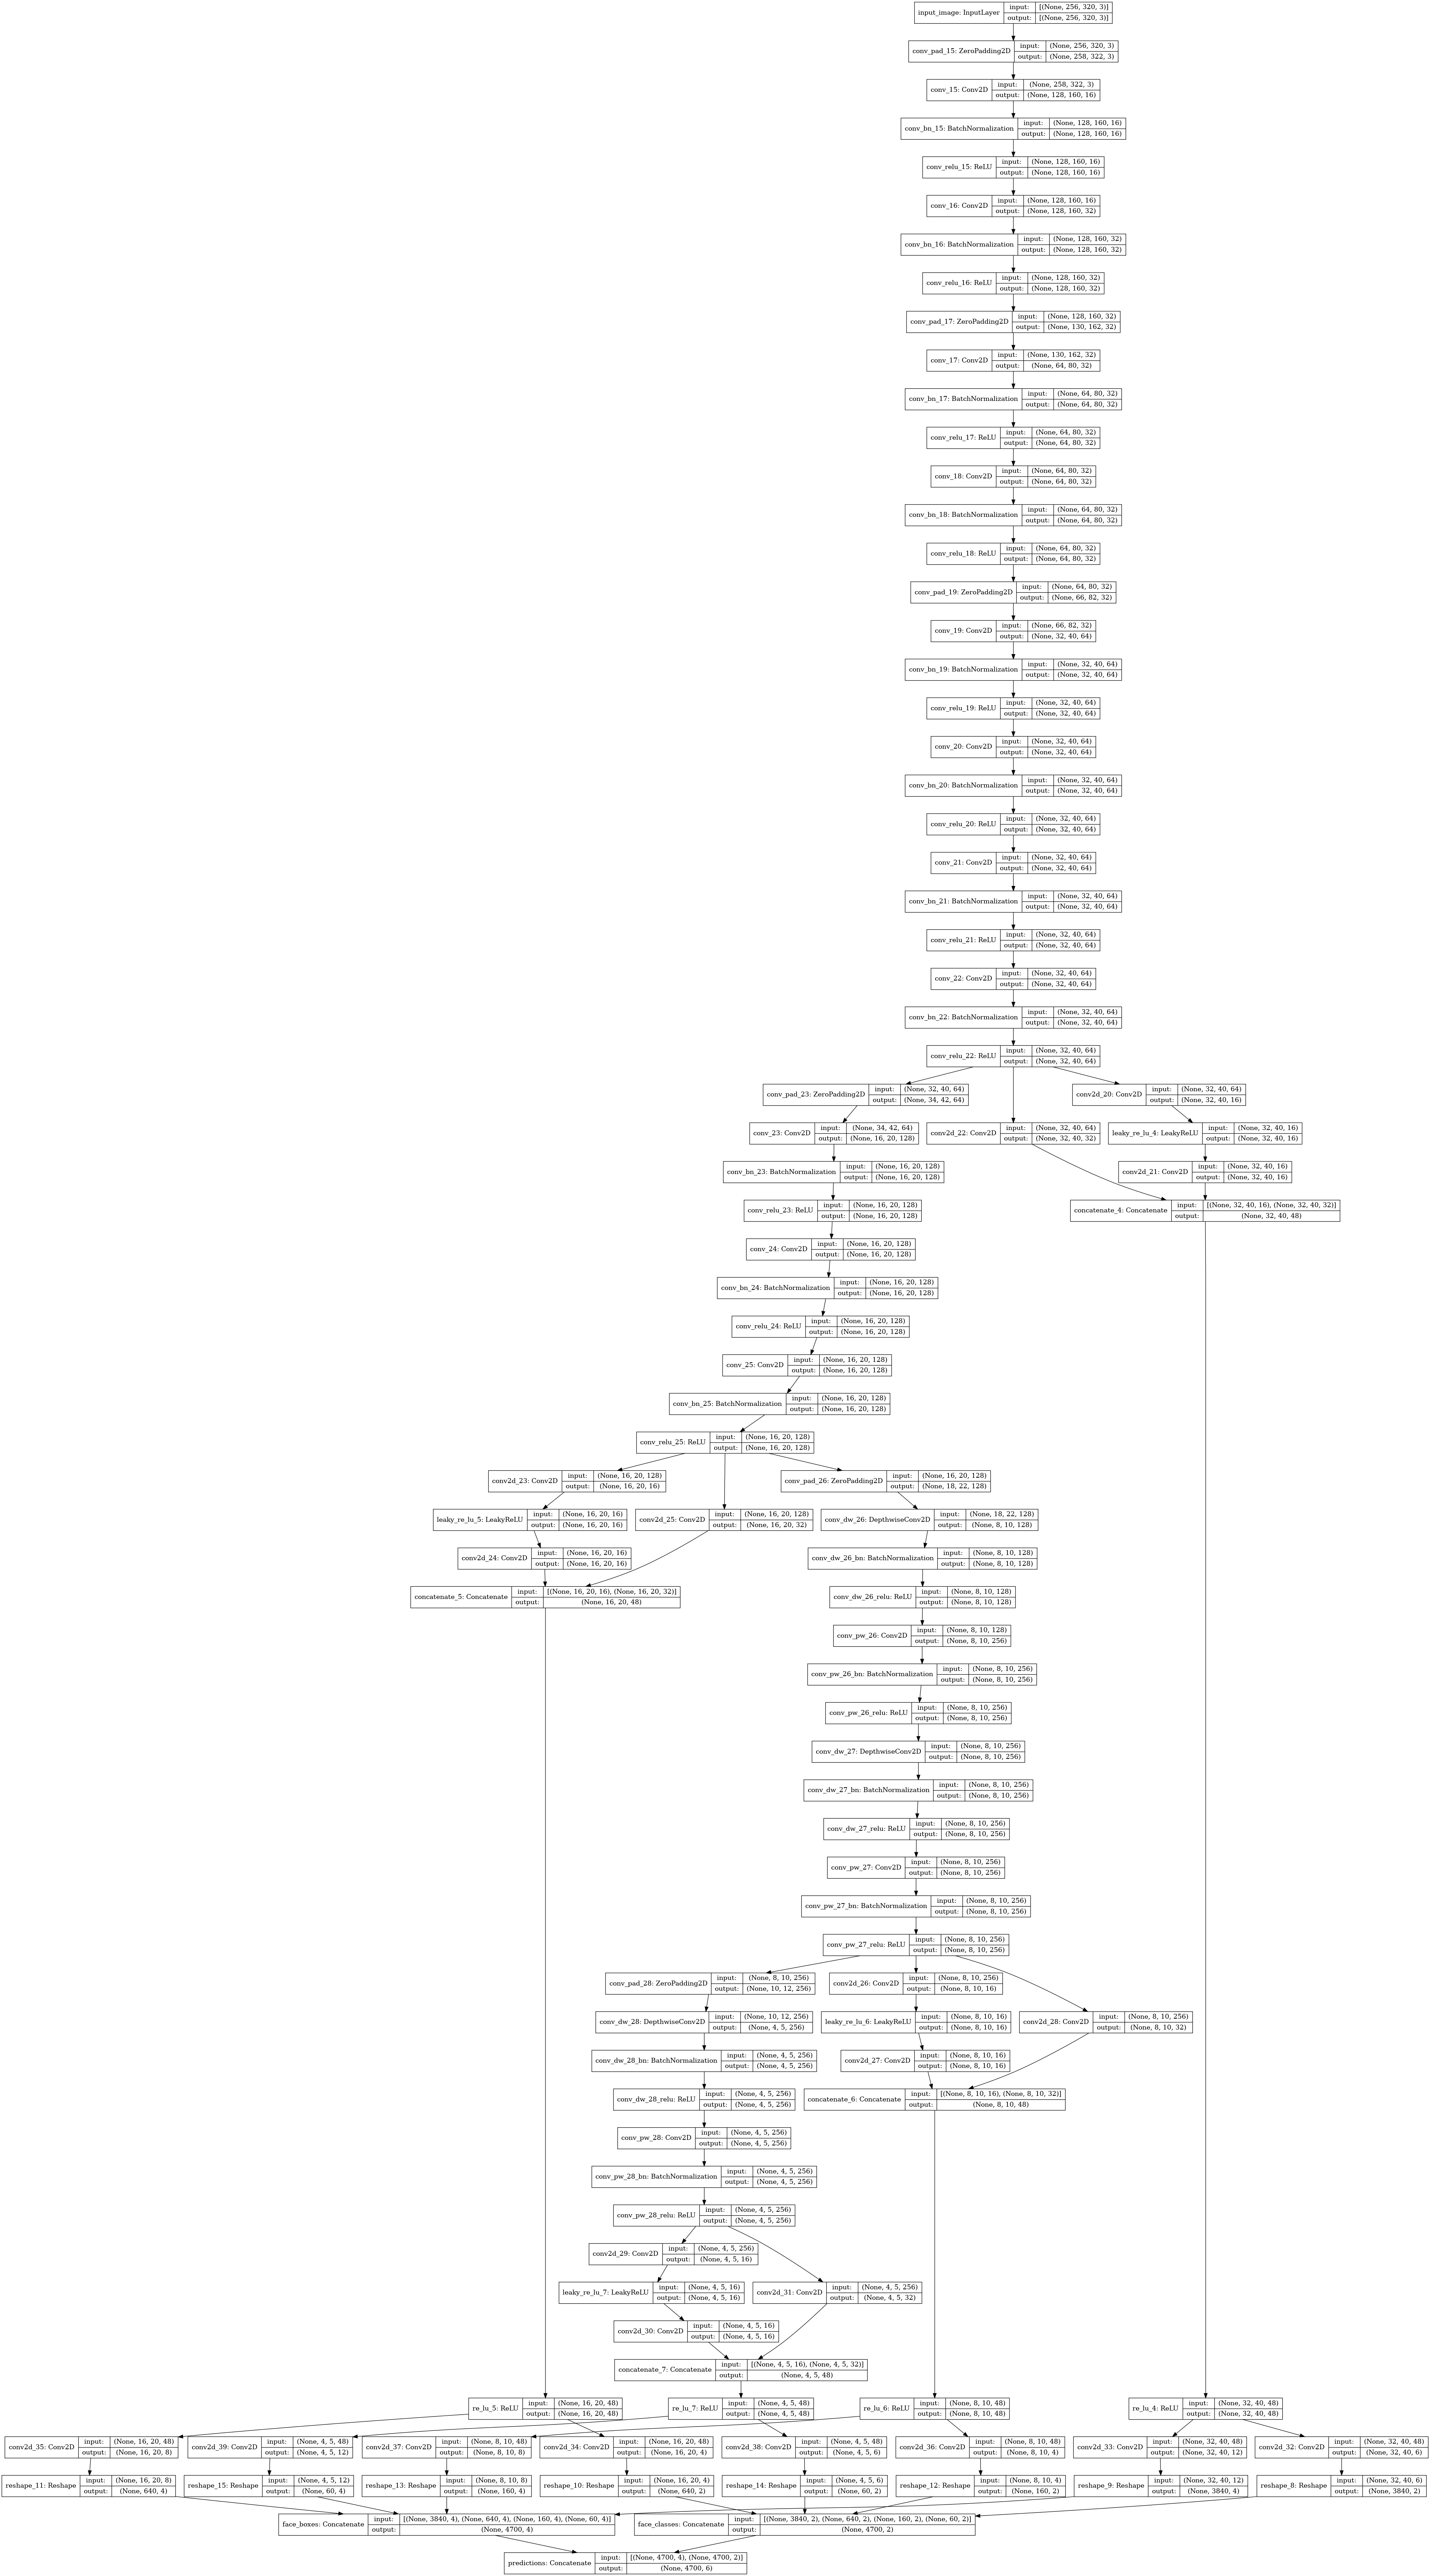

In [45]:
model = SsdModel()
model.summary()
tf.keras.utils.plot_model(
    model, 
    to_file=os.path.join(os.getcwd(), 'model.png'),
    show_shapes=True, 
    show_layer_names=True
)

나머지 학습에 필요한 요소들도 생성해 줍니다.

In [46]:
steps_per_epoch = DATASET_LEN // BATCH_SIZE
learning_rate = MultiStepWarmUpLR(
    initial_learning_rate=1e-2,
    lr_steps=[e*steps_per_epoch for e in [50, 70]],
    lr_rate=0.1,
    warmup_steps=5*steps_per_epoch,
    min_lr=1e-4
)
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

multi_loss = MultiBoxLoss(len(IMAGE_LABELS), neg_pos_ratio=3)

print('슝=3')

슝=3


이제 학습이 진행될 함수를 작성할 차례입니다. tf.GradientTape()을 사용하는 방식에 익숙해 지셨나요? 아직 어렵다면 아래 링크를 참고하세요!

- [GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape)
- [Writing a training loop from scratch](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)

한 스텝이 학습되는 함수를 아래처럼 작성합니다.

In [47]:
# @tf.function
# def train_step(inputs, labels):
#     with tf.GradientTape() as tape:
#         predictions = model(inputs, training=True)
#         losses = {}
#         losses['reg'] = tf.reduce_sum(model.losses)  #unused. Init for redefine network
#         losses['loc'], losses['class'] = multi_loss(labels, predictions)
#         total_loss = tf.add_n([l for l in losses.values()])

#     grads = tape.gradient(total_loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(grads, model.trainable_variables))

#     return total_loss, losses

# print('슝=3')

아래에서 본격적으로 train을 시작합니다. 100 epochs 이상 학습시켜야 좋은 성능을 보이지만 1 epoch 만 학습해 확인해 봅시다.

In [48]:
# def train_model(EPOCHS, train_dataset, steps_per_epoch, train_step):
#     history = {
#         'loss': [],
#         'loc_loss': [],
#         'class_loss': []
#     }

#     for epoch in range(EPOCHS):
#         epoch_loss = 0
#         epoch_loc_loss = 0
#         epoch_class_loss = 0

#         for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):
#             load_t0 = time.time()
#             total_loss, losses = train_step(inputs, labels)
#             load_t1 = time.time()
#             batch_time = load_t1 - load_t0
            
#             epoch_loss += total_loss
#             epoch_loc_loss += losses['loc']
#             epoch_class_loss += losses['class']
            
#             print(f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ", end='', flush=True)
        
#         history['loss'].append(epoch_loss / steps_per_epoch)
#         history['loc_loss'].append(epoch_loc_loss / steps_per_epoch)
#         history['class_loss'].append(epoch_class_loss / steps_per_epoch)

#     return history, model


In [49]:
def train_model(model, optimizer, EPOCHS, train_dataset, steps_per_epoch):
    @tf.function
    def train_step(inputs, labels):
        with tf.GradientTape() as tape:
            predictions = model(inputs, training=True)
            losses = {}
            losses['reg'] = tf.reduce_sum(model.losses)
            losses['loc'], losses['class'] = multi_loss(labels, predictions)
            total_loss = tf.add_n([l for l in losses.values()])

        grads = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        return total_loss, losses

    history = {
        'loss': [],
        'loc_loss': [],
        'class_loss': []
    }

    for epoch in range(EPOCHS):
        epoch_loss = 0
        epoch_loc_loss = 0
        epoch_class_loss = 0

        for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):
            load_t0 = time.time()
            total_loss, losses = train_step(inputs, labels)
            load_t1 = time.time()
            batch_time = load_t1 - load_t0
            
            epoch_loss += total_loss
            epoch_loc_loss += losses['loc']
            epoch_class_loss += losses['class']
            
            print(f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ", end='', flush=True)
        
        history['loss'].append(epoch_loss / steps_per_epoch)
        history['loc_loss'].append(epoch_loc_loss / steps_per_epoch)
        history['class_loss'].append(epoch_class_loss / steps_per_epoch)

    return history, model


In [50]:
# EPOCHS = 2

# for epoch in range(0, EPOCHS):
#     for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):
#         load_t0 = time.time()
#         total_loss, losses = train_step(inputs, labels)
#         load_t1 = time.time()
#         batch_time = load_t1 - load_t0
#         print(f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ",end = '',flush=True)

In [51]:
# model.save('my_model_02.h5')

## NMS 구현하기
---
Grid cell을 사용하는 Object detection의 inference 단계에서 하나의 object가 여러 개의 default box에 걸쳐져 있을 때 IoU가 가장 높은 default box를 선택하는 NMS(non-max suppression)이 필요합니다. 아래 코드를 확인해 주세요.

In [52]:
def compute_nms(boxes, scores, nms_threshold=0.4, limit=200):
    if boxes.shape[0] == 0:
        return tf.constant([], dtype=tf.int32)
    selected = [0]
    idx = tf.argsort(scores, direction='DESCENDING')
    idx = idx[:limit]
    boxes = tf.gather(boxes, idx)

    iou = _jaccard(boxes, boxes)

    while True:
        row = iou[selected[-1]]
        next_indices = row <= nms_threshold

        iou = tf.where(
            tf.expand_dims(tf.math.logical_not(next_indices), 0),
            tf.ones_like(iou, dtype=tf.float32),
            iou
        )

        if not tf.math.reduce_any(next_indices):
            break

        selected.append(tf.argsort(
            tf.dtypes.cast(next_indices, tf.int32), direction='DESCENDING')[0].numpy())

    return tf.gather(idx, selected)

print('슝=3')

슝=3


NMS를 통해 겹쳐진 box를 하나로 줄일 수 있게 되었다면, 이제 모델의 예측 결과를 해석해주는 함수를 작성합니다.

아래 함수에서는 모델의 예측 결과를 디코딩해서 예측 확률을 토대로 NMS를 통해 최종 box와 score 결과를 만들어 줍니다.

In [53]:
def decode_bbox_tf(predicts, boxes, variances=[0.1, 0.2]):
    centers = boxes[:, :2] + predicts[:, :2] * variances[0] * boxes[:, 2:]
    sides = boxes[:, 2:] * tf.math.exp(predicts[:, 2:] * variances[1])
    return tf.concat([centers - sides / 2, centers + sides / 2], axis=1)

print('슝=3')

슝=3


In [54]:
def parse_predict(predictions, boxes):
    label_classes = IMAGE_LABELS

    bbox_predictions, confidences = tf.split(predictions[0], [4, -1], axis=-1)
    boxes = decode_bbox_tf(bbox_predictions, boxes)

    scores = tf.math.softmax(confidences, axis=-1)

    out_boxes = []
    out_labels = []
    out_scores = []

    for c in range(1, len(label_classes)):
        cls_scores = scores[:, c]

        score_idx = cls_scores > 0.5

        cls_boxes = boxes[score_idx]
        cls_scores = cls_scores[score_idx]

        nms_idx = compute_nms(cls_boxes, cls_scores)

        cls_boxes = tf.gather(cls_boxes, nms_idx)
        cls_scores = tf.gather(cls_scores, nms_idx)

        cls_labels = [c] * cls_boxes.shape[0]

        out_boxes.append(cls_boxes)
        out_labels.extend(cls_labels)
        out_scores.append(cls_scores)

    out_boxes = tf.concat(out_boxes, axis=0)
    out_scores = tf.concat(out_scores, axis=0)

    boxes = tf.clip_by_value(out_boxes, 0.0, 1.0).numpy()
    classes = np.array(out_labels)
    scores = out_scores.numpy()

    return boxes, classes, scores

print('슝=3')

슝=3


# inference(2) 사진에서 얼굴 찾기


## 사진에서 여러개의 얼굴을 찾아보자.
---

이제 다 왔습니다. SSD 모델을 통해 우리는 Multi-face detection 기능을 확보했습니다.
얼마나 잘 해내는지 확인해 보도록 합시다.

우선 입력할 이미지의 비율이 달라도 모델이 잘 작동할 수 있도록 이미지 패딩을 추가/제거해주는 함수를 만들어 줍니다.

In [55]:
def pad_input_image(img, max_steps):
    img_h, img_w, _ = img.shape

    img_pad_h = 0
    if img_h % max_steps > 0:
        img_pad_h = max_steps - img_h % max_steps

    img_pad_w = 0
    if img_w % max_steps > 0:
        img_pad_w = max_steps - img_w % max_steps

    padd_val = np.mean(img, axis=(0, 1)).astype(np.uint8)
    img = cv2.copyMakeBorder(img, 0, img_pad_h, 0, img_pad_w,
                             cv2.BORDER_CONSTANT, value=padd_val.tolist())
    pad_params = (img_h, img_w, img_pad_h, img_pad_w)

    return img, pad_params

print('슝=3')

슝=3


In [56]:
def recover_pad(boxes, pad_params):
    img_h, img_w, img_pad_h, img_pad_w = pad_params
    box = np.reshape(boxes[0], [-1, 2, 2]) * [(img_pad_w + img_w) / img_w, (img_pad_h + img_h) / img_h]
    boxes[0] = np.reshape(box, [-1, 4])
    return boxes

아래는 최종 결과를 시각화 할 수 있도록 이미지에 box를 그려주는 함수입니다. box 사각형과 함께 확률도 표시해 줍시다.

In [57]:
def draw_box_on_face(img, boxes, classes, scores, box_index, class_list):
    img_height = img.shape[0]
    img_width = img.shape[1]

    x_min = int(boxes[box_index][0] * img_width)
    y_min = int(boxes[box_index][1] * img_height)
    x_max = int(boxes[box_index][2] * img_width)
    y_max = int(boxes[box_index][3] * img_height)

    if classes[box_index] == 1:
        color = (0, 255, 0)
    else:
        color = (0, 0, 255)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
    
    if len(scores) > box_index :
        score = "{:.4f}".format(scores[box_index])
        class_name = class_list[classes[box_index]]
        label = '{} {}'.format(class_name, score)
        position = (x_min, y_min - 4) 
        cv2.putText(img, label, position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255))

print('슝=3')

슝=3


아래 코드를 실행하여 클라우드에 저장된 테스트용 이미지의 결과를 확인해보세요.

In [58]:
print(boxes[0])

[0.0125    0.015625  0.03125   0.0390625]


In [59]:
def Test_Image(model_, PROJECT_PATH, image_path, IMAGE_WIDTH = 320, IMAGE_HEIGHT = 256, show_bbox = False):

    TEST_IMAGE_PATH = os.path.join(PROJECT_PATH, image_path)

    img_raw = cv2.imread(TEST_IMAGE_PATH)
    img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
    img = np.float32(img_raw.copy())

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))
    img = img / 255.0

    boxes = default_box()
    boxes = tf.cast(boxes, tf.float32)

    predictions = model_.predict(img[np.newaxis, ...])

    pred_boxes, labels, scores = parse_predict(predictions, boxes)
    pred_boxes = recover_pad(pred_boxes, pad_params)
    
    if show_bbox:
        for box_index in range(len(pred_boxes)):
            draw_box_on_face(img_raw, pred_boxes, labels, scores, box_index, IMAGE_LABELS)

        plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
        plt.show()
    
    return img_raw, pred_boxes

In [60]:
import matplotlib.pyplot as plt

def history_show(history):
    # 훈련 및 검증 손실 시각화
    plt.figure()
    plt.plot(history['loss'], label='loss')
    plt.plot(history['loc_loss'], label='loc loss')
    plt.plot(history['class_loss'], label='class loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [61]:
import pickle

def save_history(history, filename):
    with open(filename, 'wb') as file_pi:
        pickle.dump(history, file_pi)

def load_history(filename):
    with open(filename, 'rb') as file_pi:
        history = pickle.load(file_pi)
    return history

In [62]:
def combine_histories(old_history, new_history):
    for key in old_history.keys():
        old_history[key].extend(new_history[key])  # 수정된 부분
    return old_history

이제 학습된 모델을 테스트셋을 통해 확인해 볼 차례입니다.

In [63]:
# filepath = os.path.join(PROJECT_PATH, 'checkpoints', 'weights_epoch_008.h5')
# model.load_weights(filepath)
from tensorflow.keras.models import load_model

# model_02 = load_model('my_model_02.h5')

In [64]:
# Test_Image(model_02, PROJECT_PATH, 'image_people.png', IMAGE_WIDTH, IMAGE_HEIGHT)

## Step 1. 스티커 구하기 혹은 만들기
왕관 또는 고양이 수염 등을 구하거나 혹은 다양한 아이디어의 스티커를 만들어 볼 수 있을 것입니다.

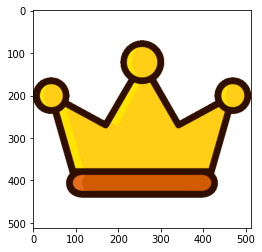

In [178]:
sticker = cv2.imread('./king.png', cv2.IMREAD_UNCHANGED)
plt.imshow(cv2.cvtColor(sticker, cv2.COLOR_BGR2RGB))
plt.show()

## Step 2. SSD 모델을 통해 얼굴 bounding box 찾기
우리는 실습 코드를 진행하며 필요한 모델을 이미 생성해 왔을 것입니다. 잘 훈련된 해당 모델을 통해 적절한 얼굴 bounding box를 찾아내 봅시다. inference.py 코드를 적극적으로 참고해 보시기를 권합니다.

- 모델 불러와서 학습 후 시각화 - 5 에폭

In [65]:
# 새로운 모델 불러오기!
model = SsdModel()
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
multi_loss = MultiBoxLoss(len(IMAGE_LABELS), neg_pos_ratio=3)

In [66]:
model.compile(optimizer=optimizer,  # 사용한 optimizer 지정
              loss=multi_loss,       # 사용자 정의 손실 함수 지정
              metrics=['accuracy'])  # 선택적으로 평가 지표 추가

In [68]:
# 모델 학습시작
history_05, model_05 = train_model(model, optimizer, 5, train_dataset, steps_per_epoch)

Epoch: 5/5 | Batch 402/402 | Batch time 0.055 || Loss: 5.180759 | loc loss:3.329410 | class loss:1.851349   

In [69]:
# 학습한 모델, 히스토리 저장
model.save('model_05.h5')
save_history(history_05, 'history_05.pkl')

In [71]:
custom_objects = {
    'PiecewiseConstantWarmUpDecay': PiecewiseConstantWarmUpDecay,
    'multi_loss': MultiBoxLoss(len(IMAGE_LABELS), neg_pos_ratio=3)
}

In [73]:
# 모델 불러오기, 사용자 정의 손실함수 명시 
model_05 = load_model('model_05.h5', custom_objects=custom_objects)

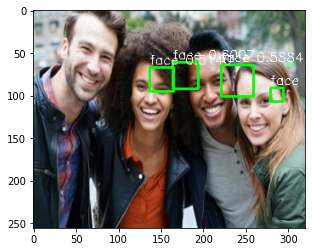

In [123]:
img_raw_05, pred_boxes_05 = Test_Image(model_05, PROJECT_PATH, 'image_people.png', IMAGE_WIDTH, IMAGE_HEIGHT, show_bbox = True)

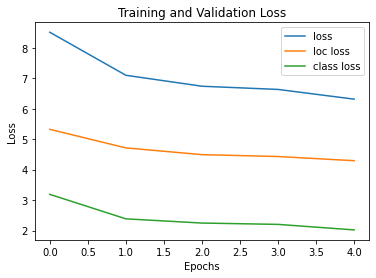

In [75]:
history_show(history_05)

- 모델 불러와서 추가학습 후 시각화 - 20 에폭

In [76]:
# 모델 불러오기, 사용자 정의 손실함수 명시 
model = load_model('model_05.h5', custom_objects=custom_objects)

In [77]:
# 모델 컴파일
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss=multi_loss, metrics=['accuracy'])

In [78]:
# 모델 추가 학습 시작 - 20 에폭
history_20, model_20 = train_model(model, optimizer, 15, train_dataset, steps_per_epoch)

Epoch: 15/15 | Batch 402/402 | Batch time 0.088 || Loss: 6.753296 | loc loss:4.993527 | class loss:1.759769  

In [79]:
# 모델 저장
model.save('model_20.h5')

In [80]:
# 이전 히스토리 불러와서 결합 후 저장
loaded_history = load_history('history_05.pkl')
history_20 = combine_histories(loaded_history, history_20)
save_history(history_20, 'history_20.pkl')

In [82]:
# 모델 불러오기
model_20 = load_model('model_20.h5', custom_objects=custom_objects)

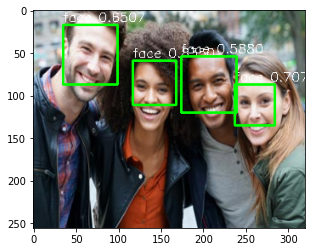

In [122]:
# 이미지 테스트
img_raw_20, pred_boxes_20 = Test_Image(model_20, PROJECT_PATH, 'image_people.png', IMAGE_WIDTH, IMAGE_HEIGHT, show_bbox = True)

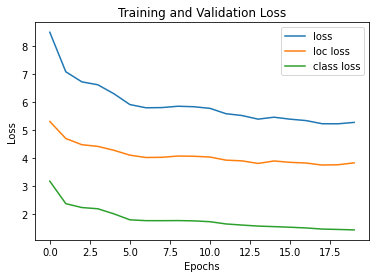

In [84]:
history_show(history_20)

- 모델 불러와서 추가학습 후 시각화 - 40 에폭

In [85]:
# 모델 불러오기, 사용자 정의 손실함수 명시 
model = load_model('model_20.h5', custom_objects=custom_objects)

In [86]:
# 모델 컴파일
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss=multi_loss, metrics=['accuracy'])

In [87]:
# 모델 추가 학습 시작 - 40 에폭
history_40, model_40 = train_model(model, optimizer, 20, train_dataset, steps_per_epoch)

Epoch: 20/20 | Batch 402/402 | Batch time 0.082 || Loss: 3.320734 | loc loss:2.135487 | class loss:1.185247  

In [88]:
# 모델 저장
model.save('model_40.h5')

In [89]:
# 이전 히스토리 불러와서 결합 후 저장
loaded_history = load_history('history_20.pkl')
history_40 = combine_histories(loaded_history, history_40)
save_history(history_40, 'history_40.pkl')

In [90]:
# 모델 불러오기
model_40 = load_model('model_40.h5', custom_objects=custom_objects)

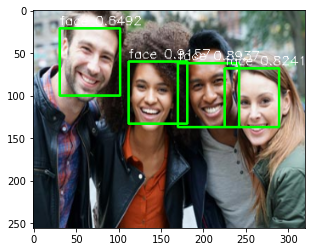

In [121]:
# 이미지 테스트
img_raw_40, pred_boxes_40 = Test_Image(model_40, PROJECT_PATH, 'image_people.png', IMAGE_WIDTH, IMAGE_HEIGHT, show_bbox = True)

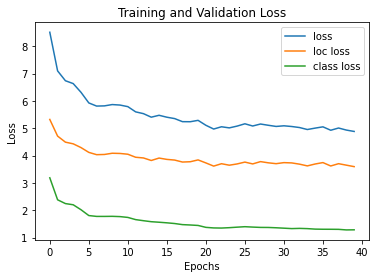

In [92]:
history_show(history_40)

- 모델 불러와서 추가 학습 후 시각화 - 60 에폭

In [93]:
# 모델 불러오기, 사용자 정의 손실함수 명시 
model = load_model('model_40.h5', custom_objects=custom_objects)

In [94]:
# 모델 컴파일
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss=multi_loss, metrics=['accuracy'])

In [95]:
# 모델 추가 학습 시작 - 40 에폭
history_60, model_60 = train_model(model, optimizer, 20, train_dataset, steps_per_epoch)

Epoch: 20/20 | Batch 402/402 | Batch time 0.057 || Loss: 4.718628 | loc loss:3.609689 | class loss:1.108939  

In [96]:
# 모델 저장
model.save('model_60.h5')

In [97]:
# 이전 히스토리 불러와서 결합 후 저장
loaded_history = load_history('history_40.pkl')
history_60 = combine_histories(loaded_history, history_60)
save_history(history_60, 'history_60.pkl')

In [98]:
# 모델 불러오기
model_60 = load_model('model_60.h5', custom_objects=custom_objects)

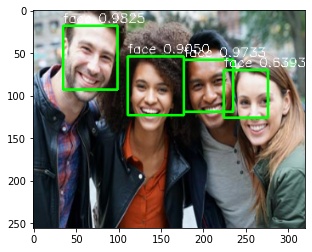

In [120]:
# 이미지 테스트
img_raw_60, pred_boxes_60 = Test_Image(model_60, PROJECT_PATH, 'image_people.png', IMAGE_WIDTH, IMAGE_HEIGHT, show_bbox = True)

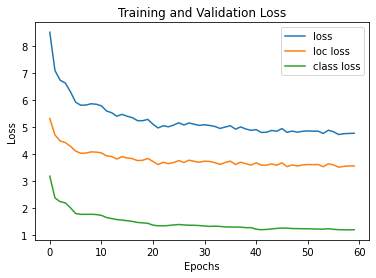

In [100]:
history_show(history_60)

- 모델 불러와서 추가 학습 후 시각화 - 80에폭

In [101]:
# 모델 불러오기, 사용자 정의 손실함수 명시 
model = load_model('model_60.h5', custom_objects=custom_objects)

In [102]:
# 모델 컴파일
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss=multi_loss, metrics=['accuracy'])

In [103]:
# 모델 추가 학습 시작 - 80 에폭
history_80, model_80 = train_model(model, optimizer, 20, train_dataset, steps_per_epoch)

Epoch: 20/20 | Batch 402/402 | Batch time 0.078 || Loss: 5.198490 | loc loss:4.084512 | class loss:1.113978  

In [104]:
# 모델 저장
model.save('model_80.h5')

In [105]:
# 이전 히스토리 불러와서 결합 후 저장
loaded_history = load_history('history_60.pkl')
history_80 = combine_histories(loaded_history, history_80)
save_history(history_80, 'history_80.pkl')

In [106]:
# 모델 불러오기
model_80 = load_model('model_80.h5', custom_objects=custom_objects)

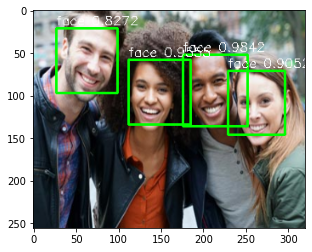

In [119]:
# 이미지 테스트
img_raw_80, pred_boxes_80 = Test_Image(model_80, PROJECT_PATH, 'image_people.png', IMAGE_WIDTH, IMAGE_HEIGHT, show_bbox = True)

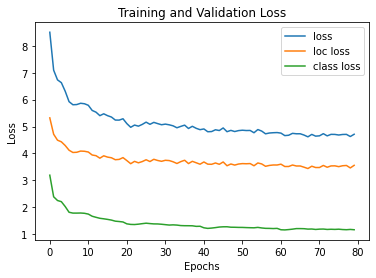

In [108]:
history_show(history_80)

- 모델 불러와서 추가 학습 후 시각화 - 100에폭

In [109]:
# 모델 불러오기, 사용자 정의 손실함수 명시 
model = load_model('model_80.h5', custom_objects=custom_objects)

In [110]:
# 모델 컴파일
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss=multi_loss, metrics=['accuracy'])

In [111]:
# 모델 추가 학습 시작 - 100 에폭
history_100, model_100 = train_model(model, optimizer, 20, train_dataset, steps_per_epoch)

Epoch: 20/20 | Batch 402/402 | Batch time 0.080 || Loss: 5.274466 | loc loss:4.171392 | class loss:1.103074 

In [112]:
# 모델 저장
model.save('model_100.h5')

In [113]:
# 이전 히스토리 불러와서 결합 후 저장
loaded_history = load_history('history_80.pkl')
history_100 = combine_histories(loaded_history, history_100)
save_history(history_100, 'history_100.pkl')

In [114]:
# 모델 불러오기
model_100 = load_model('model_100.h5', custom_objects=custom_objects)

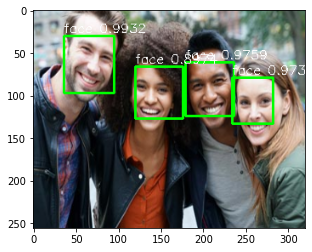

In [118]:
# 이미지 테스트
img_raw_100, pred_boxes_100 = Test_Image(model_100, PROJECT_PATH, 'image_people.png', IMAGE_WIDTH, IMAGE_HEIGHT, show_bbox = True)

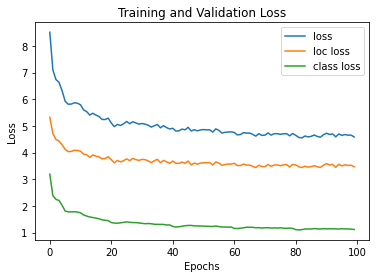

In [116]:
history_show(history_100)

## Step 3. dlib 을 이용한 landmark 찾기 (선택사항)
붙이려는 이미지에 따라 face landmark를 찾아야 할 수도 있습니다. 검출된 bounding box에 dlib을 적용해 face landmark를 찾을 수 있을 것입니다.
dlib를 이용하려는 경우, inference.py 에서 show_image 메소드를 사용한 부분을 적절히 수정해야 가능할 것입니다.

## Step 4. 스티커 합성 사진 생성하기
여러분들이 선택한 인물사진에 스티커를 합성해 봅시다. 이미지에 너무 많은 사람 얼굴이 포함되어 있거나, 검출된 얼굴이 너무 작아서 스티커 합성이 어울리지 않으면 적당하지 않겠죠? 3~5명 정도의 얼굴이 포함된 적당한 사진을 선택해 주세요.

생성된 이미지를 프로젝트 코드와 함께 제출해 주세요~

그동안 수고 많으셨습니다!!!

In [170]:
# 스티커 합성 함수

def put_sticker_on_face(img_path, img_raw_, pred_boxes_):
    # 스티커 이미지를 알파 채널을 포함하여 불러옵니다.
    sticker = cv2.imread('./king.png', cv2.IMREAD_UNCHANGED)
    
    # 얼굴 정보 추출
    return_img, pred_boxes = Test_Image()
    img_height, img_width = return_img.shape[:2]
    
    # 얼굴에 스티커 적용
    for bbox in pred_boxes:
        x_min = int(bbox[0] * img_width)
        y_min = int(bbox[1] * img_height)
        x_max = int(bbox[2] * img_width)
        y_max = int(bbox[3] * img_height)
        
        face_w = int(x_max - x_min)
        nose_point = [int((x_max + x_min) / 2), y_min]

        # 스티커 이미지 복사 및 얼굴 크기로 사이즈 조정
        temp_sticker = sticker.copy()
        temp_sticker = cv2.resize(temp_sticker, (face_w, face_w))
        
        # 스티커 이미지 위치 x, y 좌표 설정
        x = nose_point[0] - (face_w // 2)
        y = nose_point[1] - face_w

        # 스티커 위치가 원본을 벗어나는 경우 이미지 및 위치 조정
        if x < 0:
            temp_sticker = temp_sticker[:, -x:]
            x = 0
        if y < 0:
            temp_sticker = temp_sticker[-y:, :]
            y = 0

        # 스티커 적용 영역 선택
        sticker_area = return_img[y:y+temp_sticker.shape[0], x:x+temp_sticker.shape[1]]

        # 스티커 합성 (알파 채널 사용)
        for c in range(3):
            sticker_area[..., c] = np.where(temp_sticker[..., 3] == 0,
                                            sticker_area[..., c],
                                            temp_sticker[..., c])
        return_img[y:y+temp_sticker.shape[0], x:x+temp_sticker.shape[1]] = sticker_area

    return return_img

In [174]:
# 바운딩 박스 영역 찾기
img_raw_, pred_boxes_ = Test_Image(model_100, PROJECT_PATH, 'image_people.png', IMAGE_WIDTH, IMAGE_HEIGHT, show_bbox = False)

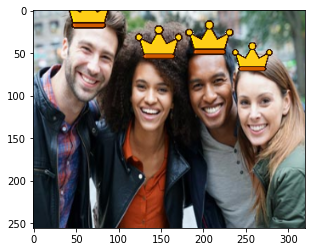

In [173]:
# 원본 이미지 얼굴에 스티커 붙인 이미지 생성 및 출력
img_result = put_sticker_on_face(os.path.join(PROJECT_PATH, 'image_people.png'), img_raw_, pred_boxes_)
plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
plt.show()

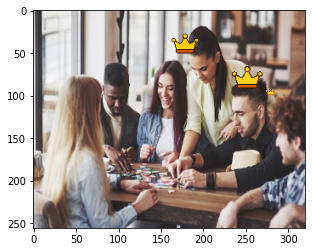

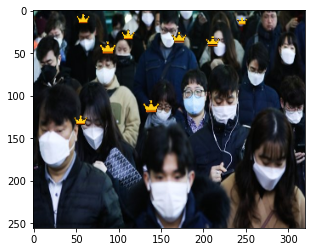

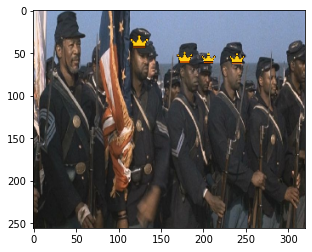

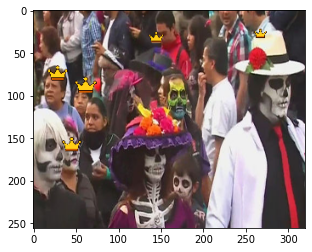

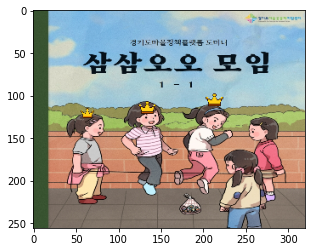

In [176]:
# 왕관 씌워주기
for i in range(1, 6):
#     img_path = os.path.join(PROJECT_PATH, f'{i}.png')
    img_raw_, pred_boxes_ = Test_Image(model_100, PROJECT_PATH, f'{i}.png', IMAGE_WIDTH, IMAGE_HEIGHT, show_bbox = False)
    
    # 원본 이미지 얼굴에 스티커 붙인 이미지 생성 및 출력
    img_result = put_sticker_on_face(os.path.join(PROJECT_PATH, f'{i}.png'), img_raw_, pred_boxes_)
    plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
    plt.show()

# --------------------- Learning rate 2배 추가 실험 -----------------------

In [179]:
steps_per_epoch = DATASET_LEN // BATCH_SIZE
learning_rate = MultiStepWarmUpLR(
    initial_learning_rate= 1e-2,
    lr_steps=[e*steps_per_epoch for e in [50, 70]],
    lr_rate=0.2,
    warmup_steps=5*steps_per_epoch,
    min_lr=1e-4
)
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

multi_loss = MultiBoxLoss(len(IMAGE_LABELS), neg_pos_ratio=3)

print('슝=3')

슝=3


In [180]:
# 새로운 모델 불러오기!
model = SsdModel()
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
multi_loss = MultiBoxLoss(len(IMAGE_LABELS), neg_pos_ratio=3)

In [181]:
model.compile(optimizer=optimizer,  # 사용한 optimizer 지정
              loss=multi_loss,       # 사용자 정의 손실 함수 지정
              metrics=['accuracy'])  # 선택적으로 평가 지표 추가

In [182]:
# 모델 학습시작
history_05_lr_02, model_05_lr_02 = train_model(model, optimizer, 5, train_dataset, steps_per_epoch)

Epoch: 5/5 | Batch 402/402 | Batch time 0.078 || Loss: 6.014758 | loc loss:4.266918 | class loss:1.747839   

In [183]:
# 학습한 모델, 히스토리 저장
model.save('model_05_lr_02.h5')
save_history(history_05_lr_02, 'history_05_lr_02.pkl')

In [184]:
custom_objects = {
    'PiecewiseConstantWarmUpDecay': PiecewiseConstantWarmUpDecay,
    'multi_loss': MultiBoxLoss(len(IMAGE_LABELS), neg_pos_ratio=3)
}

In [185]:
# 모델 불러오기, 사용자 정의 손실함수 명시 
model_05_lr_02 = load_model('model_05_lr_02.h5', custom_objects=custom_objects)

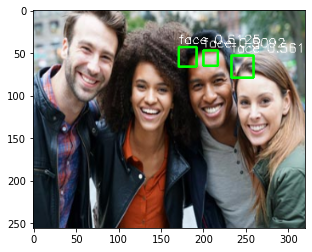

In [186]:
img_raw_05_lr_02, pred_boxes_05_lr_02 = Test_Image(model_05_lr_02, PROJECT_PATH, 'image_people.png', IMAGE_WIDTH, IMAGE_HEIGHT, show_bbox = True)

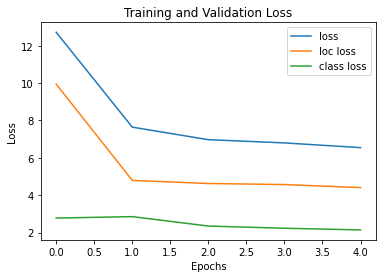

In [187]:
history_show(history_05_lr_02)

- 모델 불러와서 추가학습 후 시각화 - 20 에폭

In [188]:
# 모델 불러오기, 사용자 정의 손실함수 명시 
model = load_model('model_05_lr_02.h5', custom_objects=custom_objects)

In [189]:
# 모델 컴파일
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss=multi_loss, metrics=['accuracy'])

In [190]:
# 모델 추가 학습 시작 - 20 에폭
history_20_lr_02, model_20_lr_02 = train_model(model, optimizer, 15, train_dataset, steps_per_epoch)

Epoch: 15/15 | Batch 402/402 | Batch time 0.070 || Loss: 4.103209 | loc loss:2.832857 | class loss:1.270352  

In [191]:
# 모델 저장
model.save('model_20_lr_02.h5')

In [192]:
# 이전 히스토리 불러와서 결합 후 저장
loaded_history = load_history('history_05_lr_02.pkl')
history_20_lr_02 = combine_histories(loaded_history, history_20_lr_02)
save_history(history_20_lr_02, 'history_20_lr_02.pkl')

In [193]:
# 모델 불러오기
model_20_lr_02 = load_model('model_20_lr_02.h5', custom_objects=custom_objects)

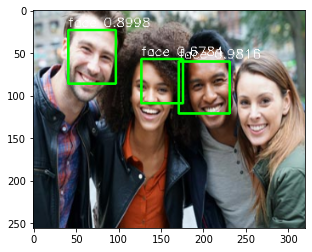

In [194]:
# 이미지 테스트
img_raw_20_lr_02, pred_boxes_20_lr_02 = Test_Image(model_20_lr_02, PROJECT_PATH, 'image_people.png', IMAGE_WIDTH, IMAGE_HEIGHT, show_bbox = True)

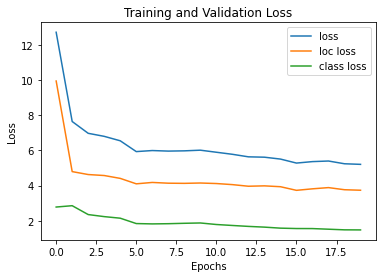

In [195]:
history_show(history_20_lr_02)

- 모델 불러와서 추가학습 후 시각화 - 40 에폭

In [196]:
# 모델 불러오기, 사용자 정의 손실함수 명시 
model = load_model('model_20_lr_02.h5', custom_objects=custom_objects)

In [197]:
# 모델 컴파일
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss=multi_loss, metrics=['accuracy'])

In [199]:
# 모델 추가 학습 시작 - 40 에폭
history_40_lr_02, model_40_lr_02 = train_model(model, optimizer, 20, train_dataset, steps_per_epoch)

Epoch: 20/20 | Batch 402/402 | Batch time 0.081 || Loss: 4.400487 | loc loss:3.402497 | class loss:0.997990  

In [200]:
# 모델 저장
model.save('model_40_lr_02.h5')

In [201]:
# 이전 히스토리 불러와서 결합 후 저장
loaded_history = load_history('history_20_lr_02.pkl')
history_40_lr_02 = combine_histories(loaded_history, history_40_lr_02)
save_history(history_40_lr_02, 'history_40_lr_02.pkl')

In [202]:
# 모델 불러오기
model_40_lr_02 = load_model('model_40_lr_02.h5', custom_objects=custom_objects)

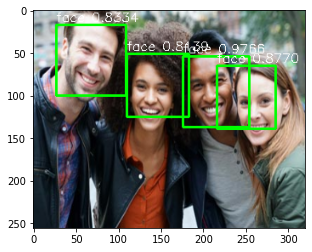

In [203]:
# 이미지 테스트
img_raw_40_lr_02, pred_boxes_40_lr_02 = Test_Image(model_40_lr_02, PROJECT_PATH, 'image_people.png', IMAGE_WIDTH, IMAGE_HEIGHT, show_bbox = True)

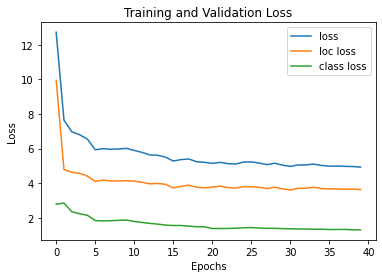

In [204]:
history_show(history_40_lr_02)

- 모델 불러와서 추가 학습 후 시각화 - 50 에폭

In [205]:
# 모델 불러오기, 사용자 정의 손실함수 명시 
model = load_model('model_40_lr_02.h5', custom_objects=custom_objects)

In [206]:
# 모델 컴파일
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss=multi_loss, metrics=['accuracy'])

In [207]:
# 모델 추가 학습 시작 - 50 에폭
history_50_lr_02, model_50_lr_02 = train_model(model, optimizer, 10, train_dataset, steps_per_epoch)

Epoch: 10/10 | Batch 402/402 | Batch time 0.087 || Loss: 4.577639 | loc loss:3.450452 | class loss:1.127187  

In [208]:
# 모델 저장
model.save('model_50_lr_02.h5')

In [209]:
# 이전 히스토리 불러와서 결합 후 저장
loaded_history = load_history('history_40_lr_02.pkl')
history_50_lr_02 = combine_histories(loaded_history, history_50_lr_02)
save_history(history_50_lr_02, 'history_50_lr_02.pkl')

In [210]:
# 모델 불러오기
model_50_lr_02 = load_model('model_50_lr_02.h5', custom_objects=custom_objects)

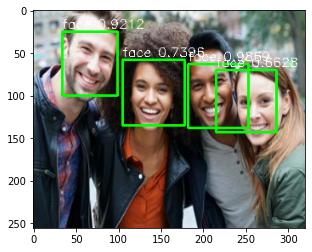

In [211]:
# 이미지 테스트
img_raw_50_lr_02, pred_boxes_50_lr_02 = Test_Image(model_50_lr_02, PROJECT_PATH, 'image_people.png', IMAGE_WIDTH, IMAGE_HEIGHT, show_bbox = True)

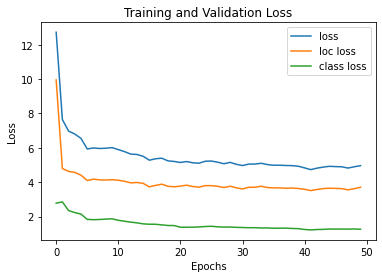

In [212]:
history_show(history_50_lr_02)

평가문항	
1. multiface detection을 위한 widerface 데이터셋의 전처리가 적절히 진행되었다.	 
상세기준 : tfrecord 생성, augmentation, prior box 생성 등의 과정이 정상적으로 진행되었다.


2. SSD 모델이 안정적으로 학습되어 multiface detection이 가능해졌다.	
상세기준 : inference를 통해 정확한 위치의 face bounding box를 detect한 결과이미지가 제출되었다.


3. 이미지 속 다수의 얼굴에 스티커가 적용되었다.	
상세기준 : 이미지 속 다수의 얼굴의 적절한 위치에 스티커가 적용된 결과이미지가 제출되었다.

## 회고록
- 이번 프로젝트는 여러 사람이 등장하는 이미지 안에서 얼굴 위치를 찾아서 BBox를 그려주는 모델을 학습시키는 것을 목표로 합니다. 그리고 그렇게 찾은 얼굴 위치에 왕관 스티커를 붙여주었습니다. 이전 노드에서 똑같은 수행을 하는 프로젝트를 했었는데, 그때는 dilib을 이용하여, landmark를 찾고, 그렇게 찾은 landmark의 좌표값을 통해 얼굴의 위치에 바운딩 박스와 왕관을 그렸습니다. 이번에는 SSD 모델을 이용하여 여러 사람의 얼굴을 디텍팅하고, 바운딩 박스를 그려주도록 모델을 학습시켰습니다. 그리고 그 위치에 맞게 왕관을 씌웠습니다.


- 배운점 : fit이 아닌 훈련 방식이 있음을 알았고, 이를 통해서 모델을 훈련하고 저장하고 다시 불러와 재학습 하는 과정에 대해 배울 수 있었습니다.


- 느낀점 : 딥러닝 분야는 아무래도 모델의 학습 시간이 길다 보니 시간 분배를 적절히 하고, 테스트를 통해 코드를 실험하고, 완성이 되었다 판단되는 코드에 대해 과감하게 에폭을 돌리는 것이 필요하다고 생각하였습니다.


- 아쉬운 점 : 학습과정에서 너무 많은 오류가 있었고, 이를 해결하기 위해 긴 에폭들을 기다려야 했습니다. 코드에 대한 이해도가 좀 더 높았다면, 이렇게까진 헤매지 않았을 텐데하는 아쉬움이 너무 컸습니다. 그렇게 소비된 시간들 뒤에 학습을 위한 에폭을 돌리는 시간도 너무 길어서 굉장히 기다리기 힘든 시간이었습니다.